In [15]:
import streamlit as st
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff
from scipy.stats import norm
from typing import List
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
from pyro.distributions import constraints
from pyro.optim import Adam

import pyro
from pyro.infer import SVI, Trace_ELBO
import torch
from tqdm.notebook import tqdm

In [2]:
def weather():
    cloudy = pyro.sample('cloudy', dist.Bernoulli(0.3))
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = pyro.sample('temp', dist.Normal(mean_temp, scale_temp))
    return cloudy, temp.item()


for _ in range(3):
    print(weather())


('cloudy', 59.80070495605469)
('cloudy', 41.41704177856445)
('sunny', 73.09033203125)


In [43]:
def model(data):
    mu = [torch.tensor(-1.),torch.tensor(1.5)]
    sd = [torch.tensor(1.),torch.tensor(1.)]
    # loop over the observed data [WE ONLY CHANGE THE NEXT LINE]
    for i in pyro.plate("data_loop", len(data)):
        # observe datapoint i using the bernoulli likelihood
        label = pyro.sample(f"label_{i}", dist.Bernoulli(0.5))
        label = 1 if label.item() == 1.0 else 0
        pyro.sample(f'obs_{i}', dist.Normal(mu[label], sd[label]), obs=data[i])



In [44]:
def guide(data):
    mu = pyro.param("mu",torch.tensor(0.05))
    sd = pyro.param("sd",torch.tensor(1.), constraint=constraints.positive)
    for i in pyro.plate("data_loop", len(data)):
        pyro.sample(f"obs_{i}", dist.Normal(mu, sd)])


In [45]:
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())


N_SAMPLES = 100
m1,m2 = -2.0, 5.0
sd1,sd2 = 1,1
d1_samples = np.random.normal(m1, sd1, N_SAMPLES)
d2_samples = np.random.normal(m2, sd2, N_SAMPLES)
data = np.concatenate([d1_samples, d2_samples])
data = torch.Tensor(data)


n_steps = 100

# do gradient steps
for step in tqdm(range(n_steps)):
    svi.step(data)
print("Mean:",pyro.param("mu").item())
print("SD:", pyro.param("mu").item())


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\reone\Anaconda3\envs\pytorch39\lib\site-packages\pyro\util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'obs_177', 'obs_159', 'obs_36', 'obs_138', 'obs_111', 'obs_197', 'obs_126', 'obs_182', 'obs_173', 'obs_105', 'obs_115', 'obs_91', 'obs_96', 'obs_186', 'obs_184', 'obs_153', 'obs_86', 'obs_121', 'obs_188', 'obs_31', 'obs_112', 'obs_148', 'obs_107', 'obs_187', 'obs_117', 'obs_57', 'obs_172', 'obs_109', 'obs_77', 'obs_106', 'obs_1', 'obs_174', 'obs_17', 'obs_75', 'obs_42', 'obs_81', 'obs_132', 'obs_85', 'obs_43', 'obs_18', 'obs_76', 'obs_56', 'obs_78', 'obs_27', 'obs_61', 'obs_46', 'obs_195', 'obs_169', 'obs_199', 'obs_44', 'obs_94', 'obs_166', 'obs_125', 'obs_73', 'obs_89', 'obs_95', 'obs_179', 'obs_70', 'obs_116', 'obs_120', 'obs_149', 'obs_142', 'obs_51', 'obs_119', 'obs_157', 'obs_110', 'obs_15', 'obs_122', 'obs_191', 'obs_58', 'obs_129', 'obs_3', 'obs_136', 'obs_71', 'obs_38', 'obs_65', 'obs_16'

Mean: -0.03984580188989639
SD: -0.03984580188989639


In [46]:
test = pyro.param("sd").item()
test


3.1312220096588135

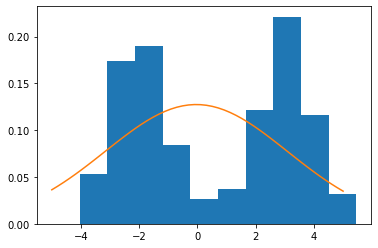

In [47]:
plt.hist(data.numpy(),density=True)
pred = norm(pyro.param("mu").item(), pyro.param("sd").item())
pdfs = pred.pdf(np.linspace(-5, 5))
plt.plot(np.linspace(-5,5),pdfs)

In [23]:

pred

In [25]:
pred.pdf(np.linspace(-5,5))

array([0.0042207 , 0.00579591, 0.00785474, 0.01050544, 0.01386659,
       0.01806332, 0.02322191, 0.0294626 , 0.0368907 , 0.0455864 ,
       0.0555938 , 0.06690984, 0.07947423, 0.09316125, 0.10777472,
       0.12304703, 0.13864303, 0.15416918, 0.16918806, 0.18323757,
       0.19585378, 0.20659606, 0.21507244, 0.22096329, 0.22404132,
       0.22418614, 0.22139206, 0.21576846, 0.2075327 , 0.19699615,
       0.1845447 , 0.17061533, 0.1556708 , 0.14017447, 0.12456709,
       0.10924721, 0.0945562 , 0.08076856, 0.06808749, 0.05664543,
       0.0465088 , 0.03768582, 0.03013655, 0.02378382, 0.01852433,
       0.01423888, 0.01080145, 0.0080865 , 0.00597464, 0.00435648])